In [1]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
train_random_iter, vocab_random_iter = d2l.load_data_time_machine(batch_size, num_steps, use_random_iter=True)

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
X = torch.arange(10).reshape((2,5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [4]:
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [5]:
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

### 初始化模型参数
接下来，我们初始化循环神经网络模型的模型参数。 隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 因此，它们具有相同的维度，即词表的大小。

In [6]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]

    for param in params:
        param.requires_grad_(True)
    return params

### 循环神经网络模型
为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

In [7]:
def init_rnn_state(batch_size, num_hidens, device):
    return (torch.zeros((batch_size, num_hidens), device=device),)

In [8]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数数量， 批量大小， b_q = params)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    # X的形状:(批量大小， 词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数。

In [9]:
class RNNModelScratch:#@save
    """ 从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。

In [10]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [11]:
def predict_ch8(prefix, num_preds, net, vocab, device):#@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda :torch.tensor([outputs[-1]], device=device).reshape((1,1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [12]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller qcqigzgeng'

In [13]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [14]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        # 在第一次迭代或使用随机抽样时初始化state
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
            y = Y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            y_hat, state = net(X, state)
            l = loss(y_hat, y.long()).mean()
            if isinstance(updater, torch.optim.Optimizer):
                updater.zero_grad()
                l.backward()
                grad_clipping(net, 1)
                updater.step()

            else:
                l.backward()
                grad_clipping(net, 1)
                # 因为已经调用了mean函数
                updater(batch_size=1)
            metric.add(l*y.numel(), y.numel())
        return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [15]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',legend=['train'], xlim=[10,num_epochs])

    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix:predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch+1)%10==0:
            predict(predict('time traverller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

ZeroDivisionError: float division by zero

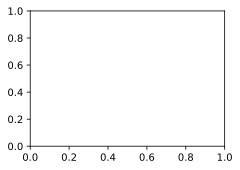

In [16]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())